In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
project_id = 'gad-playground-212407'
sql = """SELECT 
            unique_key
            , taxi_id
            , trip_start_timestamp
            , trip_end_timestamp
            , trip_seconds
            , trip_miles
            , pickup_census_tract
            , dropoff_census_tract
            , pickup_community_area
            , dropoff_community_area
            , pickup_latitude
            , pickup_longitude
            , dropoff_latitude
            , dropoff_longitude
            , payment_type
            FROM `gad-playground-212407.chicago_taxi.sample_table`"""
df = pd.read_gbq(sql, project_id=project_id, dialect='standard')

In [3]:
df['trip_start_timestamp'] = df['trip_start_timestamp'].apply(pd.Timestamp)
df['trip_end_timestamp'] = df['trip_end_timestamp'].apply(pd.Timestamp)

In [4]:
df['unique_key'] = df['unique_key'].apply(str)

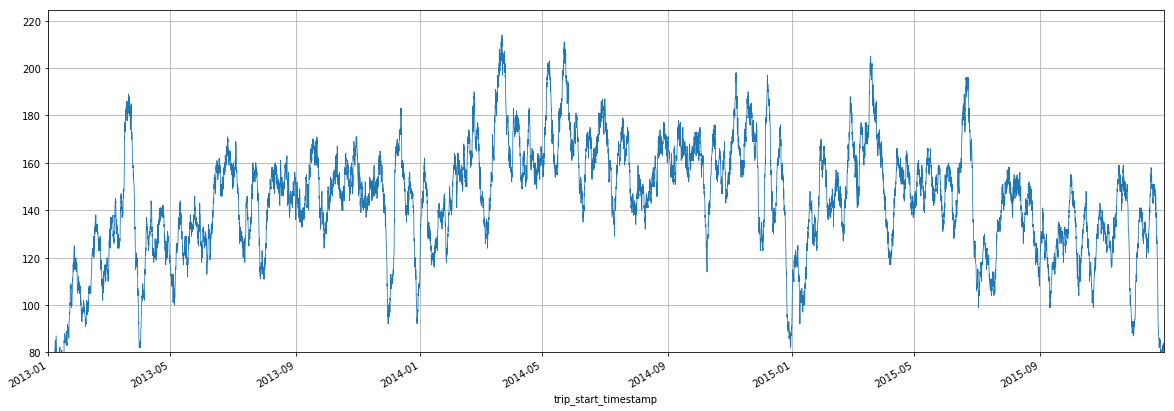

In [5]:
total_trips = df.set_index('trip_start_timestamp').sort_index()['trip_miles'].fillna(0).rolling('7d').count()
total_trips.plot(lw=0.8, figsize=(20,7))
plt.ylim(80,)
plt.grid()
plt.show()

In [6]:
df['trip_speed_kmph'] = (df['trip_miles'] * (1.60934)) / ((df['trip_seconds'] + .01)/ (60 * 60))

In [7]:
# Impute data
df = df[df['trip_miles'] > 0.2]
df = df[df['trip_seconds'] > 2]
df = df[df['trip_speed_kmph'].between(5,120)]

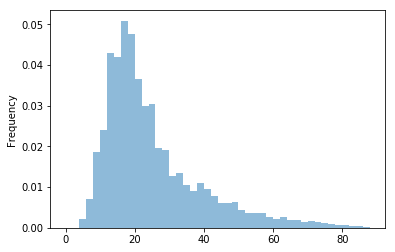

In [13]:
df['trip_speed_kmph'].dropna().plot(kind='hist', bins=range(0,90, 2), alpha=0.5, density=True)
plt.show()

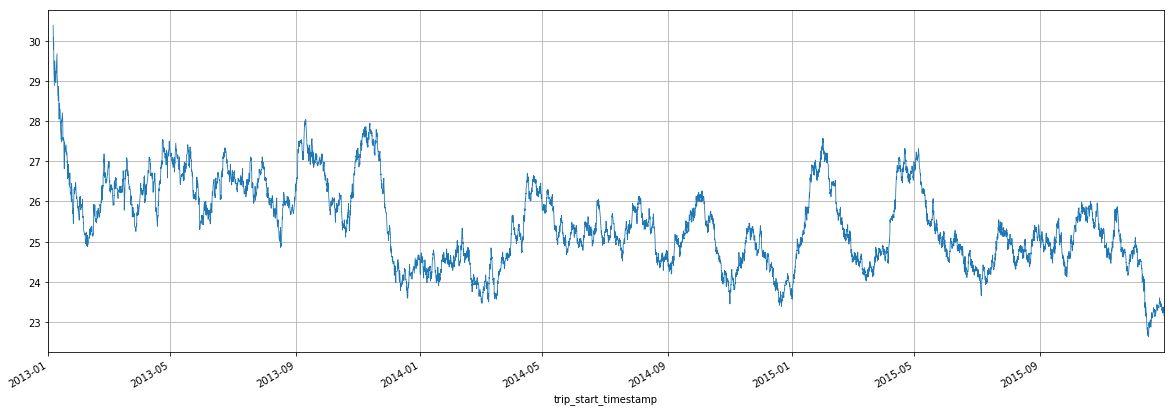

In [18]:
total_trips = df.set_index('trip_start_timestamp').sort_index()['trip_speed_kmph'].fillna(0).rolling('30d', min_periods=30).mean()
total_trips.plot(lw=0.8, figsize=(20,7))
plt.grid()
plt.show()

In [19]:
df['hour_of_day'] = df['trip_start_timestamp'].dt.hour
df['day_of_week'] = df['trip_start_timestamp'].dt.weekday

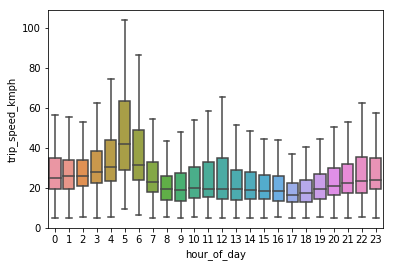

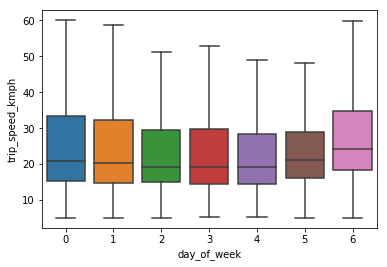

In [24]:
sns.boxplot(x='hour_of_day', y='trip_speed_kmph', data=df, showfliers=False)
plt.show()
sns.boxplot(x='day_of_week', y='trip_speed_kmph', data=df, showfliers=False)
plt.show()

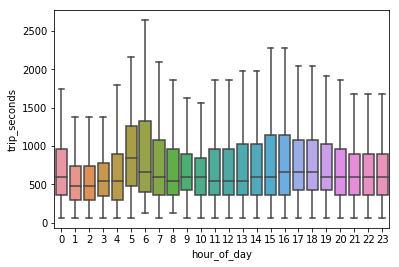

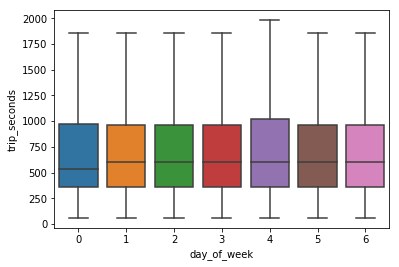

In [25]:
sns.boxplot(x='hour_of_day', y='trip_seconds', data=df, showfliers=False)
plt.show()
sns.boxplot(x='day_of_week', y='trip_seconds', data=df, showfliers=False)
plt.show()